# Predicting Tritium Thermo-Desorption Spectra

*** 


### What is tritium desorption?

The interior of the reactor wall is bombarded by tritium isotopes from the tritium breeding loop and plasma bombardment, resulting in adsorption and diffusion through the material. 

Additionally to the mobile tritium which diffuses through the material, there are regions of the atomic lattice called trapping sites, whereby tritium can become trapped in a potential well of a given energy. Understanding both the diffusion of the mobile tritium and the energy and density of these traps is essential in predicting the amount of tritium which is retained within the fusion reactor structures. This has implications in the required tritium breeding ratio, tritium inventory, future waste classification and material degradation. Characteristing these trapping sites is therefore essential in making engineering predictions of future fusion powerplants.

If the material is heated up above a certain termperature, the tritium can become excited and released from these trapping site. This can be measured through an experiment known as thermal-desorption spectrometry. A piece of material which has been implanted with tritium is heated at incremental steps, with the amount of tritium released being measured as a function of temperature. the physical properties of these traps can then be determined from the characteristics of the spectra.

*** 

### ML Challenge 

Computer simulations are required to model the behaviour of these materials over a range of parameters, but simulations are expensive in terms of computational power, and cannot be run at every point in parameter space under consideration. `twinLab` can be used to train simulation surrogate models using data from a sparse array of simulations. This allows for meaningful interpolation and extrapolation to unexplored regions of parameter space, together with a calibrated uncertainty estimate on the accuracy of the simulation surrogate.

In this example, we look at the ability of `twinLab` Gaussian Processes to model of tritium in the wall of a fusion reactor using tritium desorption spectra. 

Taking a training set of known correlations between tritium desorption spectra (TDS) of form $f(T)$ and physical trapping properties ($E_1$, $E_2$, $E_3$, $n_1$, $n_2$), a Gaussian Process can then be traing to predict the shape of a TDS given a any new set of physical parameters along with the uncertainty in these predictions.

***

### Importing libraries

First, import the required libraries

In [1]:
# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Project imports
import twinlab as tl


          ====== TwinLab Client Initialisation ======
          Version     : 2.9.0
          Server      : https://twinlab.digilab.co.uk
          Environment : /Users/joe/repos/FusionEnergy/.env



We need to provide `twinLab` with locations of data files (in `.csv` format) and directories, together with a chosen surrogate emulator name (here `tritium_desorption`) and a list of the input parameters that we are going to use as inputs to our model. 

***

### Importing data

In [2]:
data = tl.load_example_dataset('tritium-desorption')

In [3]:
df_train = data.iloc[:900, :]
df_test = data.iloc[-100:, :]

df_grid = pd.DataFrame(np.linspace(300, 800, 624))

In [4]:
df_train.head()

,E1,E2,E3,n1,n2,y0,y1,y2,y3,y4,...,y614,y615,y616,y617,y618,y619,y620,y621,y622,y623
0,0.726163,1.248766,1.128671,0.002004,0.000307,1.511613e+17,1.626357e+17,1.749599e+17,1.881609e+17,2.022474e+17,...,2.318606e+17,2.304607e+17,2.290609e+17,2.276611e+17,2.262613e+17,2.248615e+17,2.234616e+17,2.220618e+17,2.206620e+17,2.192622e+17
1,0.787837,0.925174,1.226117,0.001564,0.000768,7.621430e+16,8.255297e+16,8.942421e+16,9.684174e+16,1.048160e+17,...,2.728998e+16,2.706896e+16,2.684793e+16,2.662690e+16,2.640587e+16,2.618484e+16,2.596381e+16,2.574279e+16,2.552176e+16,2.530073e+16
2,0.710103,0.902457,1.558539,0.004860,0.000613,2.376907e+17,2.553641e+17,2.743015e+17,2.945655e+17,3.161688e+17,...,2.079730e+16,2.078486e+16,2.077242e+16,2.075998e+16,2.074754e+16,2.073510e+16,2.072265e+16,2.071021e+16,2.069777e+16,2.068533e+16
3,0.757797,1.187059,1.479970,0.002868,0.000841,1.491269e+17,1.609964e+17,1.737868e+17,1.875378e+17,2.022633e+17,...,2.405455e+17,2.382445e+17,2.359435e+17,2.336425e+17,2.313415e+17,2.290405e+17,2.267395e+17,2.244385e+17,2.221375e+17,2.198365e+17
4,0.880510,0.987709,1.305003,0.001307,0.000302,8.396414e+15,9.173453e+15,1.003567e+16,1.097871e+16,1.200347e+16,...,3.434468e+16,3.408240e+16,3.382012e+16,3.355785e+16,3.329557e+16,3.303329e+16,3.277101e+16,3.250873e+16,3.224646e+16,3.198418e+16


***

### View the training data

### Inputs

In [5]:
df_train.iloc[:,:5].head()

,E1,E2,E3,n1,n2
0,0.726163,1.248766,1.128671,0.002004,0.000307
1,0.787837,0.925174,1.226117,0.001564,0.000768
2,0.710103,0.902457,1.558539,0.004860,0.000613
3,0.757797,1.187059,1.479970,0.002868,0.000841
4,0.880510,0.987709,1.305003,0.001307,0.000302


### Outputs

In [6]:
df_train.iloc[:,5:].head()

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y614,y615,y616,y617,y618,y619,y620,y621,y622,y623
0,1.511613e+17,1.626357e+17,1.749599e+17,1.881609e+17,2.022474e+17,2.171753e+17,2.329431e+17,2.501679e+17,2.681171e+17,2.873808e+17,...,2.318606e+17,2.304607e+17,2.290609e+17,2.276611e+17,2.262613e+17,2.248615e+17,2.234616e+17,2.220618e+17,2.206620e+17,2.192622e+17
1,7.621430e+16,8.255297e+16,8.942421e+16,9.684174e+16,1.048160e+17,1.133235e+17,1.223659e+17,1.323483e+17,1.428036e+17,1.541191e+17,...,2.728998e+16,2.706896e+16,2.684793e+16,2.662690e+16,2.640587e+16,2.618484e+16,2.596381e+16,2.574279e+16,2.552176e+16,2.530073e+16
2,2.376907e+17,2.553641e+17,2.743015e+17,2.945655e+17,3.161688e+17,3.390432e+17,3.631858e+17,3.895231e+17,4.169486e+17,4.463476e+17,...,2.079730e+16,2.078486e+16,2.077242e+16,2.075998e+16,2.074754e+16,2.073510e+16,2.072265e+16,2.071021e+16,2.069777e+16,2.068533e+16
3,1.491269e+17,1.609964e+17,1.737868e+17,1.875378e+17,2.022633e+17,2.179179e+17,2.345022e+17,2.527081e+17,2.717244e+17,2.922129e+17,...,2.405455e+17,2.382445e+17,2.359435e+17,2.336425e+17,2.313415e+17,2.290405e+17,2.267395e+17,2.244385e+17,2.221375e+17,2.198365e+17
4,8.396414e+15,9.173453e+15,1.003567e+16,1.097871e+16,1.200347e+16,1.310722e+16,1.429071e+16,1.561696e+16,1.701622e+16,1.854882e+16,...,3.434468e+16,3.408240e+16,3.382012e+16,3.355785e+16,3.329557e+16,3.303329e+16,3.277101e+16,3.250873e+16,3.224646e+16,3.198418e+16


### Temperature grid:

In [7]:
df_grid.head()

,0
0,300.000000
1,300.802568
2,301.605136
3,302.407705
4,303.210273


The 5 parameters $E_1$, $E_2$, $E_3$, $n_1$, and $n_2$ are physical properties of the material characterising the trapping of tritium isotopes.

- $E_i$ refers to the detrapping energies of tritium trap sites in $eV$. 
- $n_i$ are the densities of the trapping site.

The incrementing number $i$ relates to discrete trapping sites.

It might be noticed that the trapping density $n_3$ which should compliment $E_3$ is not present. This trap is an implantation trap created through irradiation damage and is not considered in this model.

### View the test data

In [8]:
df_test.head()

,E1,E2,E3,n1,n2,y0,y1,y2,y3,y4,...,y614,y615,y616,y617,y618,y619,y620,y621,y622,y623
300,0.700338,1.150021,1.710087,0.004111,0.000930,2.021919e+17,2.169475e+17,2.327300e+17,2.495828e+17,2.675127e+17,...,2.974306e+17,2.932256e+17,2.890206e+17,2.848157e+17,2.806107e+17,2.764057e+17,2.722007e+17,2.679958e+17,2.637908e+17,2.595858e+17
301,0.910138,1.132486,1.682557,0.004323,0.000657,9.677587e+15,1.061440e+16,1.165152e+16,1.278887e+16,1.402926e+16,...,2.185340e+17,2.147866e+17,2.110392e+17,2.072918e+17,2.035444e+17,1.997969e+17,1.960495e+17,1.923021e+17,1.885547e+17,1.848073e+17
302,0.864146,1.011063,1.535927,0.003682,0.000942,3.051326e+16,3.331790e+16,3.638907e+16,3.973493e+16,4.336344e+16,...,6.721837e+16,6.657205e+16,6.592572e+16,6.527939e+16,6.463306e+16,6.398674e+16,6.334041e+16,6.269408e+16,6.204776e+16,6.140143e+16
303,0.785364,0.914528,1.494170,0.004685,0.000446,1.469481e+17,1.591239e+17,1.722814e+17,1.864735e+17,2.017193e+17,...,2.596674e+16,2.577841e+16,2.559007e+16,2.540174e+16,2.521341e+16,2.502508e+16,2.483675e+16,2.464842e+16,2.446009e+16,2.427175e+16
304,0.850848,0.943984,1.476743,0.001971,0.000751,2.501309e+16,2.727755e+16,2.975959e+16,3.246143e+16,3.538895e+16,...,3.578703e+16,3.551876e+16,3.525050e+16,3.498224e+16,3.471397e+16,3.444571e+16,3.417744e+16,3.390918e+16,3.364091e+16,3.337265e+16


***

### Uploading data to the `twinLab` cloud

In [9]:
dataset = tl.Dataset("tritium_desorption")

dataset.upload(df_train, verbose=True)

Dataframe is uploading.
Processing dataset
Dataset tritium_desorption was processed.


### Define the columns

In [10]:
inputs = ["E1", "E2", "E3", "n1", "n2"]
outputs = [f"y{i}" for i in range(len(df_grid))]

### Check dataset has uploaded

In [11]:
dataset_summary = dataset.summarise()
dataset_summary

,E1,E2,E3,n1,n2,y0,y1,y2,y3,y4,...,y614,y615,y616,y617,y618,y619,y620,y621,y622,y623
count,400.000000,400.000000,400.000000,400.000000,400.000000,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,...,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02
mean,0.847811,1.096564,1.439218,0.002780,0.000550,6.361675e+16,6.873802e+16,7.426884e+16,8.022546e+16,8.661425e+16,...,1.576280e+17,1.556983e+17,1.537915e+17,1.519250e+17,1.501097e+17,1.483684e+17,1.466999e+17,1.450814e+17,1.435212e+17,1.420506e+17
std,0.086283,0.113226,0.183739,0.001264,0.000254,6.795742e+16,7.317686e+16,7.878150e+16,8.479061e+16,9.120958e+16,...,1.292721e+17,1.276754e+17,1.260886e+17,1.245359e+17,1.230176e+17,1.216074e+17,1.202565e+17,1.189713e+17,1.177443e+17,1.165804e+17
min,0.700338,0.902457,1.103538,0.000522,0.000100,1.963621e+14,2.115386e+14,2.298551e+14,2.515298e+14,2.763921e+14,...,1.460660e+16,1.447977e+16,1.435294e+16,1.422611e+16,1.409927e+16,1.397244e+16,1.385901e+16,1.379510e+16,1.373119e+16,1.366728e+16
25%,0.776996,1.004006,1.280775,0.001742,0.000322,3.537697e+15,3.885903e+15,4.276821e+15,4.708195e+15,5.180239e+15,...,5.655948e+16,5.534897e+16,5.479281e+16,5.426104e+16,5.364998e+16,5.317452e+16,5.268290e+16,5.221749e+16,5.175208e+16,5.128668e+16
50%,0.846752,1.089826,1.435188,0.002727,0.000586,3.677477e+16,3.990621e+16,4.332506e+16,4.702728e+16,5.106477e+16,...,1.074164e+17,1.056007e+17,1.036920e+17,1.023300e+17,1.009598e+17,9.926862e+16,9.720451e+16,9.593318e+16,9.500944e+16,9.441496e+16
75%,0.923479,1.195031,1.588289,0.003888,0.000756,1.154598e+17,1.245779e+17,1.343340e+17,1.446751e+17,1.557012e+17,...,2.294064e+17,2.254695e+17,2.217749e+17,2.188035e+17,2.164698e+17,2.153460e+17,2.142763e+17,2.121939e+17,2.109158e+17,2.095455e+17
max,0.997323,1.299867,1.748338,0.004999,0.000995,2.376907e+17,2.553641e+17,2.743015e+17,2.945655e+17,3.161688e+17,...,5.888639e+17,5.804446e+17,5.720253e+17,5.663434e+17,5.610157e+17,5.556881e+17,5.518733e+17,5.513362e+17,5.507992e+17,5.502622e+17


### Dimensional reduction

In [12]:
variance = dataset.analyse_variance(outputs)

In [13]:
variance.iloc[:10]

,Number of Dimensions,Cumulative Variance
0,0,0.000000
1,1,0.265579
2,2,0.734992
3,3,0.895238
4,4,0.969070
5,5,0.989724
6,6,0.996053
7,7,0.998313
8,8,0.999210
9,9,0.999563


(0.9, 1.01)

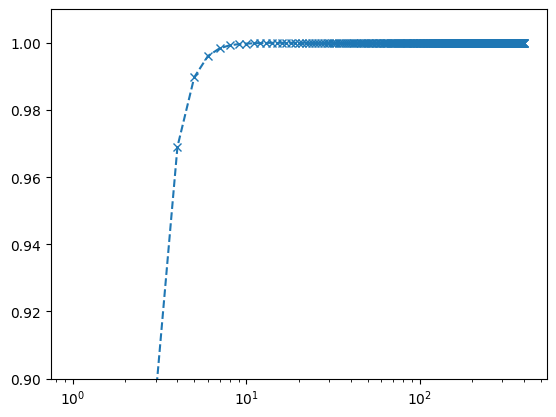

In [14]:
plt.plot(variance['Number of Dimensions'], variance['Cumulative Variance'], 'x--')
plt.xscale('log')
plt.ylim(0.9,1.01)

*** 

### Setting up an emulator

In this case we are training a functional model, which means that we want to return a *function* at every point in parameter space ($E_1$, $E_2$, $E_3$, $n_1$, $n_2$). In this case, our function describes the tritium desorption rate, $D$, of the material of the reactor wall as a function of temperature (rate of emitted nuclei per reactor wall area). The training of the surrogate is agnostic to the values of reactor temperature, $T$, so we must provide this by hand (`df_grid` above, from `file_grid`). The output of our model will therefore be the function $D(T; E_1, E_2, E_3, n_1, n_2)$.

The `twinLab` model achieves this by predicting the value of $D$ at $\sim 500$ points in $T$ in a regularly-spaced grid between $300\mathrm{K}$ and $800\mathrm{K}$. The correlations between points adjacent in $T$ are incorporated naturally by the model, and `twinLab` provides a model uncertainty. Here we call the outputs `y`, rather than `D`, as per the typical data-science convention.

### Instantiate emulator

In [15]:
emulator = tl.Emulator('tritium_desorption') 

### Set emulator parameters

In [16]:
estimator_params = tl.EstimatorParams(detrend=False, covar_module='M32', estimator_type='single_task_gp')
train_params = tl.TrainParams(output_retained_dimensions=5,
                              estimator_params=estimator_params, 
                              train_test_ratio=0.8)

### Train the emulator 

In [17]:
emulator.train(dataset, inputs, outputs, train_params)

Model tritium_desorption has begun training.
Emulator tritium_desorption with process ID train-pointed-deadpan-crowd is training.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job is currently being processed.
Training status: Your job has finished and is on its way back to you.
Training of emulator tritium_desorption with process ID train-pointed-deadpan-crowd is complete!


## Check emulator score

In [18]:
print(f"MSE  = {emulator.score(tl.ScoreParams(metric='MSE', combined_score=True))}")

MSE  = 3.037412674132691e+34


In [19]:
df_test[inputs].head()

,E1,E2,E3,n1,n2
300,0.700338,1.150021,1.710087,0.004111,0.000930
301,0.910138,1.132486,1.682557,0.004323,0.000657
302,0.864146,1.011063,1.535927,0.003682,0.000942
303,0.785364,0.914528,1.494170,0.004685,0.000446
304,0.850848,0.943984,1.476743,0.001971,0.000751


Evaluate the trained emulator on `X` ($E_1, E_2, E_3, n_1, n_2$) from the evaluation file

In [20]:
df_mean, df_std = emulator.predict(df_test[inputs], verbose=False)

display(df_mean.head())
display(df_std.head())

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y614,y615,y616,y617,y618,y619,y620,y621,y622,y623
0,1.591912e+17,1.711598e+17,1.839973e+17,1.977359e+17,2.123831e+17,2.278925e+17,2.442620e+17,2.621202e+17,2.807172e+17,3.006540e+17,...,3.073816e+17,3.036422e+17,2.999568e+17,2.964032e+17,2.929031e+17,2.896494e+17,2.865022e+17,2.835551e+17,2.808164e+17,2.782503e+17
1,7.065916e+15,7.889660e+15,8.813882e+15,9.839647e+15,1.096995e+16,1.220221e+16,1.353777e+16,1.506105e+16,1.668147e+16,1.847959e+16,...,2.550416e+17,2.518373e+17,2.486506e+17,2.455327e+17,2.425458e+17,2.397315e+17,2.370485e+17,2.344516e+17,2.319415e+17,2.295423e+17
2,2.642444e+16,2.900185e+16,3.183275e+16,3.492726e+16,3.829283e+16,4.192053e+16,4.581260e+16,5.017689e+16,5.478211e+16,5.982706e+16,...,8.290070e+16,8.187312e+16,8.085027e+16,7.983030e+16,7.888612e+16,7.793499e+16,7.704431e+16,7.613384e+16,7.519612e+16,7.429609e+16
3,1.561150e+17,1.687376e+17,1.823632e+17,1.970373e+17,2.127782e+17,2.295389e+17,2.473212e+17,2.668929e+17,2.873620e+17,3.094627e+17,...,5.991632e+16,5.889060e+16,5.787290e+16,5.682793e+16,5.579261e+16,5.477091e+16,5.373235e+16,5.280295e+16,5.186542e+16,5.084643e+16
4,3.042704e+16,3.314013e+16,3.609783e+16,3.931050e+16,4.278422e+16,4.650936e+16,5.048745e+16,5.491433e+16,5.956885e+16,6.463823e+16,...,5.853760e+16,5.772521e+16,5.691381e+16,5.609260e+16,5.531644e+16,5.454874e+16,5.380890e+16,5.308746e+16,5.235716e+16,5.161125e+16


,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y614,y615,y616,y617,y618,y619,y620,y621,y622,y623
0,1.363900e+16,1.454539e+16,1.550656e+16,1.652527e+16,1.760140e+16,1.873155e+16,1.991535e+16,2.118976e+16,2.250899e+16,2.390850e+16,...,4.947436e+16,4.880170e+16,4.812941e+16,4.744205e+16,4.674173e+16,4.612195e+16,4.552654e+16,4.498794e+16,4.446727e+16,4.399398e+16
1,1.350918e+16,1.440612e+16,1.535721e+16,1.636517e+16,1.742989e+16,1.854800e+16,1.971914e+16,2.097983e+16,2.228482e+16,2.366914e+16,...,4.929724e+16,4.862722e+16,4.795754e+16,4.727265e+16,4.657478e+16,4.595724e+16,4.536416e+16,4.482755e+16,4.430854e+16,4.383722e+16
2,1.352606e+16,1.442423e+16,1.537663e+16,1.638599e+16,1.745219e+16,1.857187e+16,1.974466e+16,2.100714e+16,2.231398e+16,2.370027e+16,...,4.932020e+16,4.864984e+16,4.797982e+16,4.729461e+16,4.659643e+16,4.597860e+16,4.538522e+16,4.484835e+16,4.432912e+16,4.385754e+16
3,1.528375e+16,1.633413e+16,1.745188e+16,1.864034e+16,1.989975e+16,2.122623e+16,2.261950e+16,2.412639e+16,2.568994e+16,2.735509e+16,...,5.121749e+16,5.052584e+16,4.983495e+16,4.913102e+16,4.841587e+16,4.778133e+16,4.717199e+16,4.661898e+16,4.608487e+16,4.559896e+16
4,1.352089e+16,1.441868e+16,1.537068e+16,1.637961e+16,1.744536e+16,1.856456e+16,1.973685e+16,2.099878e+16,2.230506e+16,2.369075e+16,...,4.931313e+16,4.864288e+16,4.797296e+16,4.728785e+16,4.658976e+16,4.597202e+16,4.537874e+16,4.484195e+16,4.432279e+16,4.385129e+16


*** 

### Test the emulator 

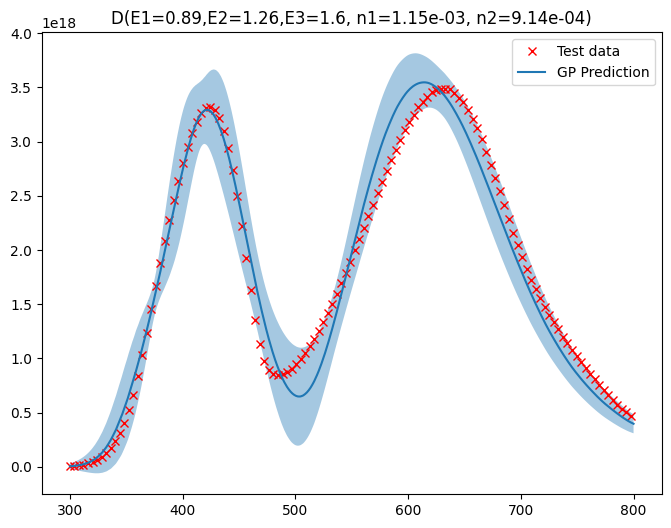

In [21]:
i = 50

if i > len(df_test): 
    raise ValueError('The index given is out of the range of the test dataframe')

df_mean_i = df_mean.iloc[i].values
df_std_i = df_std.iloc[i].values
df_test_i = df_test.iloc[i,5::].values
params = df_test.iloc[i,:5].values

fig = plt.figure(figsize=(8,6))
plt.plot(df_grid[::5], df_test_i[::5],'xr', label='Test data')
plt.plot(df_grid, df_mean_i, label='GP Prediction')
plt.fill_between(df_grid[0], df_mean_i-2*df_std_i, df_mean_i+2*df_std_i, alpha=0.4)
plt.title(f'D(E1={round(params[0],2)},E2={round(params[1],2)},E3={round(params[2],2)}, n1={params[3]:.2e}, n2={params[4]:.2e})')
plt.legend()

# Load the streamlit App

In [ ]:
%%capture
!streamlit run app.py